# Modèle HarderLASSO linéaire (fonction de coût square-root $\ell_2$ et pénalité "Subbotin" $P_{\nu}$)

Je me repose uniquement sur l'article *"Training a neural network for data interpretation and better generalization: towards intelligent artificial intelligence"* de **Sylvain Sardy**, **Maxime van Custsem** et **Xiaoyu Ma**

In [1]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent.parent.parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

## Théorie

### Fondamentaux

On résout ce problème de minimisation :

$$\min_{\boldsymbol{\beta}^{(1)}\in\mathbb{R}^{\gamma_1},\boldsymbol{\beta}^{(2)}\in\mathbb{R}^{\gamma_2}}\mathcal{L}_n(\mu_{(\boldsymbol{\beta}^{(1)},\boldsymbol{\beta}^{(2)})};\mathbf{y},X)+\lambda P(\boldsymbol{\beta}^{(1)})$$

où 
- $P$ est une pénalité
- $\lambda$ le coefficient de pénalisation
- $\mathcal{L}_n$ est une fonction de coût
  - avec $\mu_{(\boldsymbol{\beta}^{(1)},\boldsymbol{\beta}^{(2)})}$ le "Learner".

On remarque ici que seul les paramètres $\boldsymbol{\beta}^{(2)}$ sont pénalisés. On a $\gamma_1 + \gamma_2 = p$.



Seulement pas toutes les paires ($\mathcal{L}_n$, $P$) sont QUT-compatible !

On prends dans notre cas le couple choisis ici pour la méthode HarderLASSO :

$$ \boxed{\text{HarderLASSO} := (P_{\nu}, \|\cdot\|_2)}$$ 

En plus pour n'importe quel valeurs de $\nu$, $\lambda_{\alpha}^{\mathrm{QUT}}(X)$ est le même !

### $P_{\nu}$ ?

$$P_\nu(\boldsymbol{\beta})=\sum_{j=1}^p\rho_\nu(\boldsymbol{\beta}_j)\quad\mathrm{avec}\quad\rho_\nu(\boldsymbol{\beta})=\frac{\|\boldsymbol{\beta}\|_2}{1+\|\boldsymbol{\beta}\|_2^{1-\nu}}$$

### $\lambda_0(\cdot)$ ?

##### **Cas : Régression linéaire avec fonction coût square-root et pénalité $P_\nu$** ($\xi = \beta$)

On cherche pour quel $\lambda$ la solution du problème  
$$
\hat{\beta}_\lambda(y) = \arg\min_{\beta} \|y - X\beta\|_2 + \lambda P_\nu(\beta)
$$  
devient nulle, avec  
$$
P_\nu(\beta) = \sum_{j=1}^p \frac{|\beta_j|}{1 + |\beta_j|^{1 - \nu}} \quad \text{avec } \nu \in (0,1]
$$

On note $r = y - X\beta$. La fonction $\beta \mapsto \|r\|_2$ n'est pas différentiable partout (au point $r = 0$), mais elle est sub-différentiable sur $\mathbb{R}^n \setminus \{0\}$.

On considère la sous-différentielle du critère au point $\beta = 0$ :
$$
\partial \left( \|y - X\beta\|_2 + \lambda P_\nu(\beta) \right) \quad \text{au point } \beta = 0
$$

Comme $\beta = 0$, on a $r = y$, donc :
$$
\partial \left( \|y - X\beta\|_2 \right) = -\frac{X^\top y}{\|y\|_2} \quad \text{(valide si } y \neq 0\text{)}
$$

Concernant $P_\nu$, sa dérivée à droite en zéro vaut $1$ pour tout $\nu \in (0,1]$, donc :
$$
\partial P_\nu(\beta)\big|_{\beta = 0} = \{v \in \mathbb{R}^p : v_j \in [-1, 1] \text{ pour tout } j\}
$$

Pour que $\beta = 0$ soit une solution (minimum local), il faut :
$$
0 \in -\frac{X^\top y}{\|y\|_2} + \lambda \cdot \partial P_\nu(\beta)\big|_{\beta=0}
$$
soit :
$$
\frac{X^\top y}{\|y\|_2} \in \lambda \cdot \partial P_\nu(0)
$$

Donc chaque composante de $\frac{X^\top y}{\|y\|_2}$ doit être dans $[-\lambda, \lambda]$ :
$$
\left\| \frac{X^\top y}{\|y\|_2} \right\|_\infty \leq \lambda
$$

Ce qui donne :
$$
\lambda_0^{\text{local}}(y) = \left\| \frac{X^\top y}{\|y\|_2} \right\|_\infty
$$

Cette forme a l’avantage d’être **pivotal**, c’est-à-dire que $\lambda_0^{\text{local}}(y)$ **ne dépend pas** du bruit $\sigma$, et est donc directement exploitable pour la sélection via le QUT. C'est la même que pour le modèle Square root avec pénalité $\ell_1$.

### $\lambda_\text{QUT}$ ?

On réutilise la même fonction que dans le cas square root avec pénalité $\ell_1$.

### Optimisation

$z_j = \beta_j^{(k)} - \delta \left( \nabla f(\beta^{(k)}) \right)_j$

## Simulations

In [2]:
n = 5
p = 10
list_s = range(0, 6)

sigma = 1
nu = 0.1

simu_iter=1
qut_iter=1000
max_iter=10000
tol=1e-8

seed=43

### HARDER LASSO avec ISTA backtracking

|0| Simulations pour s = 0 :
  → z_j = -0.018, threshold = 2.591, output = 0.000
  → z_j = -0.096, threshold = 2.591, output = 0.000
  → z_j = -0.071, threshold = 2.591, output = 0.000
  → z_j = -0.088, threshold = 2.591, output = 0.000
  → z_j = 0.016, threshold = 2.591, output = 0.000
  → z_j = -0.051, threshold = 2.591, output = 0.000
  → z_j = 0.022, threshold = 2.591, output = 0.000
  → z_j = -0.132, threshold = 2.591, output = 0.000
  → z_j = 0.122, threshold = 2.591, output = 0.000
  → z_j = -0.111, threshold = 2.591, output = 0.000
	 |1| Simulation 1/1 :
		 beta : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
		 beta estimé : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
		 Lambda : 2.593098512975192
		 Score :
			pesr : 1.0
			f1 : 0.0
			tpr : 0.0
			fdr : 0.0
	 Score :
		pesr : [1.0]
		f1 : [0.0]
		tpr : [0.0]
		fdr : [0.0]
|1| Simulations pour s = 1 :
  → z_j = 0.177, threshold = 2.591, output = 0.000
  → z_j = -0.052, threshold = 2.591, output = 0.000
  → z_j = 0.059, threshold = 2.591, output = 0.00

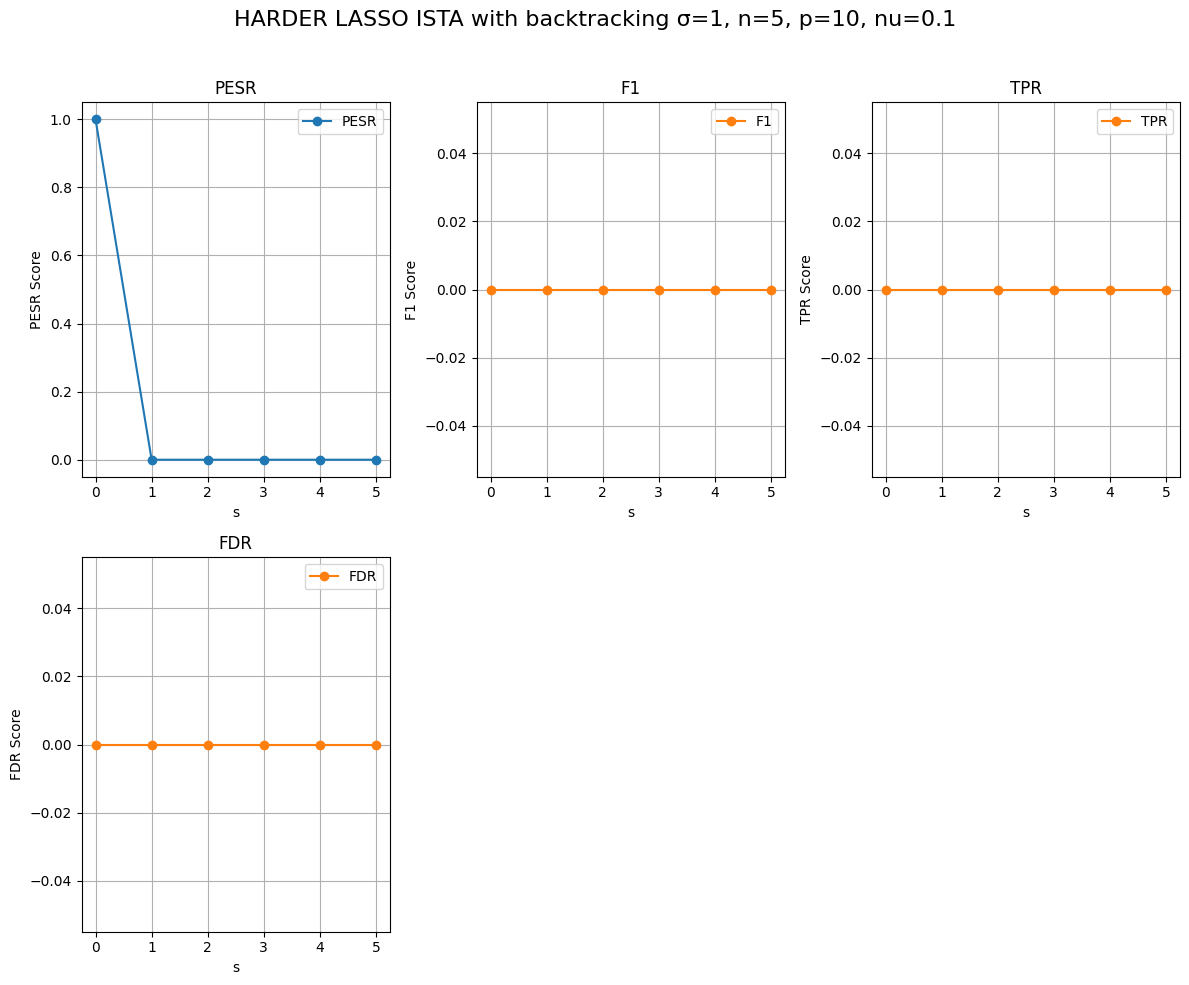

In [3]:
from simulations import SimulationHarderLassoIstaBacktracking

Sim = SimulationHarderLassoIstaBacktracking(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    nu = nu,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=True
)

Sim.run()

Sim.plot()